In [13]:
from importlib import reload
import ananke.models.collection
from ananke.models.collection import Collection
reload(ananke.models.collection)
import ananke.models.collection
from ananke.configurations.collection import MergeConfiguration
from ananke.schemas.event import RecordType
from ananke.configurations.events import EventRedistributionMode
from ananke.configurations.collection import HDF5StorageConfiguration
import Trigger_Parallel_Working as tc
reload(tc)
import Trigger_Parallel_Working as tc
import cProfile
import pstats
import matplotlib.pyplot as plt
import os
import logging
import numpy as np
# Configure logging to display DEBUG messages
logging.basicConfig(level=logging.INFO)

In [4]:
x={
        'in_collections': [
            {
                'type': 'hdf5',
                'data_path':'data/LargeStarting/0.h5',
                'read_only':'False',
            },
            {
                'type': 'hdf5',
                'data_path':'data/LargeStarting/1.h5',
                'read_only':'False',
            },
            {
                'type': 'hdf5',
                'data_path': 'data/Hex_electrical_noise_10_BM.h5',
                'read_only':'False',
            },
            
        ],
        'out_collection': {
                'type': 'hdf5',
                'data_path': 'data/LargeSMerge/1.h5',
                'read_only':'False',
        },
        'content': [
            {
                'primary_type': RecordType.STARTING_TRACK.value,
                'secondary_types': [RecordType.ELECTRICAL.value,RecordType.BIOLUMINESCENCE],
                'number_of_records': 1,
                'interval': {
                    'start': 5000,
                    'end': 10000,
                }
            },
        ],
        # 'redistribution': {
        #     'interval': {
        #         'start': 0,
        #         'end': 10000
        #     },
        #     'mode': EventRedistributionMode.CONTAINS_EVENT,
        # }
           
     }

In [94]:
path='data/'
configuration = MergeConfiguration.parse_obj(
    {
        'in_collections': [
            {
                'type': 'hdf5',
                'data_path':'data/LargeCascades/15records/0.h5',
                'read_only':'False',
            },
            {
                'type': 'hdf5',
                'data_path': 'data/LargeElectrical/20records/0.h5',
                'read_only':'False',
            },
            {
                'type': 'hdf5',
                'data_path': 'data/LargeBio/100000s/0.h5',
                'read_only':'False',
            },
            
        ],
        'out_collection': {
                'type': 'hdf5',
                'data_path': 'data/LargeCMerge/1rec/4.h5',
                'read_only':'False',
        },
        'content': [
            {
                'primary_type': RecordType.CASCADE.value,
                'secondary_types': [RecordType.ELECTRICAL.value,RecordType.BIOLUMINESCENCE],
                'number_of_records': 1,
                'interval': {
                    'start': 0,
                    'end': 100000,
                }
            },
        ],
        # 'redistribution': {
        #     'interval': {
        #         'start': 5000,
        #         'end': 100000
        #     },
        #     'mode': EventRedistributionMode.CONTAINS_PERCENTAGE,
        #  }
           
     }
)

print(configuration.redistribution)

None


In [110]:
#R=configuration.redistribution
R.mode=EventRedistributionMode.START_TIME

In [96]:
C2=Collection.from_merge(configuration)

INFO:root:Starting to merge collections with config.
INFO:root:Starting to create joined temporary collection.
100it [00:24,  4.02it/s]              
INFO:Collection:Starting to append collection.
100%|██████████| 100/100 [01:33<00:00,  1.07it/s]
INFO:Collection:Finished to append collection.
INFO:Collection:Starting to append collection.
100it [00:23,  4.20it/s]              
INFO:Collection:Finished to append collection.
INFO:root:Finished creating joined temporary collection.
INFO:root:Starting to create 1 RecordType.CASCADE records
INFO:root:Secondary types: 20, 21
100%|██████████| 1/1 [00:05<00:00,  5.55s/it]
INFO:root:Finished to create 1 RecordType.CASCADE records
INFO:root:Finished to merge collections with config.


In [98]:
with C2:
    hit=C2.storage.get_hits()
    records=C2.storage.get_records()
    sources=C2.storage.get_sources()

In [111]:
with C2:
    C2.redistribute(R)
    hit1=C2.storage.get_hits()
    records1=C2.storage.get_records()
    sources1=C2.storage.get_sources()

INFO:Collection:Starting to redistribute with mode: start_time
100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
INFO:Collection:Finished to redistribute with mode: start_time


In [108]:
sources.df.equals(sources.df)

True

In [107]:
display(records.df.head())
display(records1.df.head())

,location_x,location_y,location_z,orientation_x,orientation_y,orientation_z,record_id,energy,length,time,type,particle_id,duration
0,94.046895,13.59135,-99.321267,0.707838,0.701491,0.082922,16,104984.752378,3000.0,0.0,1,11,NaN


,location_x,location_y,location_z,orientation_x,orientation_y,orientation_z,record_id,energy,length,time,type,particle_id,duration
0,94.046895,13.59135,-99.321267,0.707838,0.701491,0.082922,16,104984.752378,3000.0,-6176.170641,1,11,NaN


In [118]:
hits.df

,time,string_id,module_id,pmt_id,record_id,type
0,1104.965874,4,0,0,14,0
1,1122.459863,4,0,0,14,0
2,1230.520131,4,0,0,14,0
3,1232.213440,4,0,2,14,0
4,1104.965687,4,0,4,14,0
...,...,...,...,...,...,...
1357,9.962088,13,19,0,14,20
1358,773.729854,13,19,0,14,20
1359,596.038141,13,19,6,14,20
1360,971.174044,13,19,10,14,20


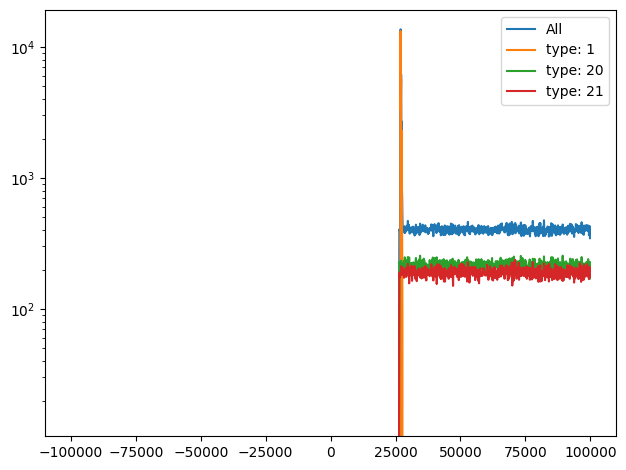

In [112]:
t_all=hit1.df['time']
t_1=hit1.df[hit.df['type']==1]['time']
t_20=hit1.df[hit.df['type']==20]['time']
t_21=hit1.df[hit.df['type']==21]['time']

bins=np.arange(-100_000,100_000,100)
t_all_h,intervals=np.histogram(t_all,bins=bins)
t_1_h,intervals=np.histogram(t_1,bins=bins)
t_20_h,intervals=np.histogram(t_20,bins=bins)
t_21_h,intervals=np.histogram(t_21,bins=bins)

interval=(intervals[1:]+intervals[:-1])/2

plt.plot(interval,t_all_h,label='All')
plt.plot(interval,t_1_h,label='type: 1')
plt.plot(interval,t_20_h,label='type: 20')
plt.plot(interval,t_21_h,label='type: 21')
#ax.plt(f"Record id: {record}")
plt.legend()
#ax.set_xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

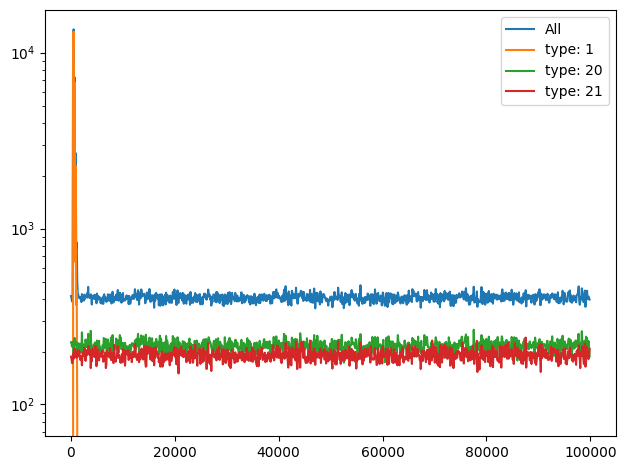

In [101]:
t_all=hit.df['time']
t_1=hit.df[hit.df['type']==1]['time']
t_20=hit.df[hit.df['type']==20]['time']
t_21=hit.df[hit.df['type']==21]['time']

bins=np.arange(0,100_000,100)
t_all_h,intervals=np.histogram(t_all,bins=bins)
t_1_h,intervals=np.histogram(t_1,bins=bins)
t_20_h,intervals=np.histogram(t_20,bins=bins)
t_21_h,intervals=np.histogram(t_21,bins=bins)

interval=(intervals[1:]+intervals[:-1])/2

plt.plot(interval,t_all_h,label='All')
plt.plot(interval,t_1_h,label='type: 1')
plt.plot(interval,t_20_h,label='type: 20')
plt.plot(interval,t_21_h,label='type: 21')
#ax.plt(f"Record id: {record}")
plt.legend()
#ax.set_xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

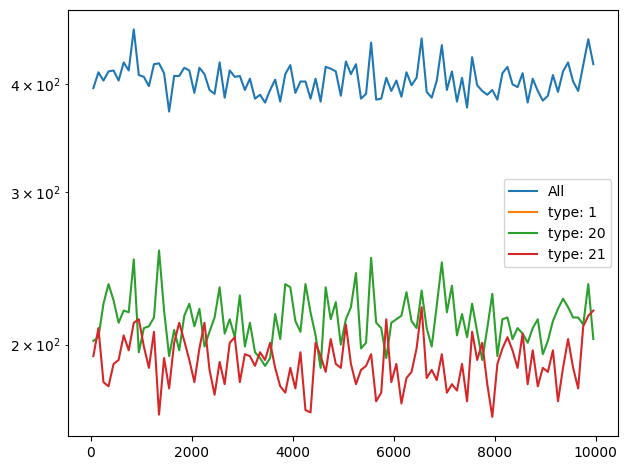

In [77]:
t_all=hit.df['time']
t_1=hit.df[hit.df['type']==1]['time']
t_20=hit.df[hit.df['type']==20]['time']
t_21=hit.df[hit.df['type']==21]['time']

bins=np.arange(0,10001,100)
t_all_h,intervals=np.histogram(t_all,bins=bins)
t_1_h,intervals=np.histogram(t_1,bins=bins)
t_20_h,intervals=np.histogram(t_20,bins=bins)
t_21_h,intervals=np.histogram(t_21,bins=bins)

interval=(intervals[1:]+intervals[:-1])/2

plt.plot(interval,t_all_h,label='All')
plt.plot(interval,t_1_h,label='type: 1')
plt.plot(interval,t_20_h,label='type: 20')
plt.plot(interval,t_21_h,label='type: 21')
#ax.plt(f"Record id: {record}")
plt.legend()
#ax.set_xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [64]:
for x in [0,20,21]:
    temp=hits.df[hits.df['type']==x]
    for i in temp['record_id'].drop_duplicates():
        temp1=temp[temp['record_id']==i]
        print(f"hits counts for record {i} type {x} is {temp1.shape[0]}")

hits counts for record 7 type 0 is 31795
hits counts for record 5 type 0 is 7527
hits counts for record 3 type 0 is 341699
hits counts for record 17 type 0 is 312922
hits counts for record 20 type 0 is 1489776
hits counts for record 9 type 0 is 32772
hits counts for record 6 type 0 is 336480
hits counts for record 11 type 0 is 141895
hits counts for record 14 type 0 is 9389
hits counts for record 21 type 0 is 315556
hits counts for record 2 type 0 is 315556
hits counts for record 8 type 0 is 64050
hits counts for record 12 type 0 is 38948
hits counts for record 4 type 0 is 252649
hits counts for record 22 type 0 is 57938
hits counts for record 23 type 0 is 3803
hits counts for record 24 type 0 is 145941
hits counts for record 25 type 0 is 1206015
hits counts for record 26 type 0 is 625460
hits counts for record 27 type 0 is 57938
hits counts for record 10 type 0 is 253843
hits counts for record 28 type 0 is 31795
hits counts for record 29 type 0 is 277815
hits counts for record 30 type

In [41]:
path = "data/LargeStarting/"
for i in ['0.h5','1.h5']:
    config=HDF5StorageConfiguration(data_path=path+i,read_only=False)
    C1=Collection(config)
    with C1:
        hits=C1.storage.get_hits()
        records=C1.storage.get_records().df['record_id']
    for j in records:
        print(f"record {j} with count {hits.get_by_record_ids(j).get_statistics().count}")

record 0 with count 136634
record 3 with count 5279
record 4 with count 245479
record 5 with count 1937
record 6 with count 23750
record 7 with count 25744
record 8 with count 35073
record 9 with count 3803
record 10 with count 114073
record 12 with count 3761
record 14 with count 646
record 15 with count 524
record 17 with count 192
record 18 with count 1
record 19 with count 2170
record 0 with count 2744
record 2 with count 2826
record 3 with count 307451
record 4 with count 3367
record 5 with count 5590
record 7 with count 3225
record 8 with count 8
record 10 with count 392
record 11 with count 2517
record 12 with count 11437
record 14 with count 5917
record 15 with count 188
record 18 with count 2362
record 20 with count 1177046
record 21 with count 1


In [ ]:
hits['record_id'].drop_duplicates().shap

In [3]:
result=tc.run(path='data/LargeStarting/0.h5')

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
INFO:root:Record 3 started processing.
INFO:root:Record 7 started processing.
INFO:root:Record 0 started processing.
INFO:root:Record 8 started processing.
INFO:root:Record 4 started processing.
INFO:root:Record 9 started processing.
INFO:root:Record 6 started processing.
INFO:root:Record 5 started processing.
INFO:root:Time taken for record 5: 4.79 seconds
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   12.0s
INFO:root:Record 10 started processing.
INFO:root:Time taken for record 9: 5.92 seconds
[Parallel(n_jobs=8)]: Done   2 out of  15 | elapsed:   13.2s remaining:  1.4min
INFO:root:Record 12 started processing.
INFO:root:Time taken for record 3: 6.91 seconds
INFO:root:Record 14 started processing.
INFO:root:Time taken for record 14: 3.69 seconds
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:   17.9s remaining:   49.2s
INFO:root:Record 15 started processing.
INFO:root:Time taken for record 12: 5.8

In [4]:
path='data/LargeStarting/0.h5'
config=HDF5StorageConfiguration(data_path=path,read_only=False)
C=Collection(config)

In [5]:
with C:
    hits=C.storage.get_hits()
    records=C.storage.get_records()

In [6]:
import numpy as np

In [7]:
intervals=result[3]

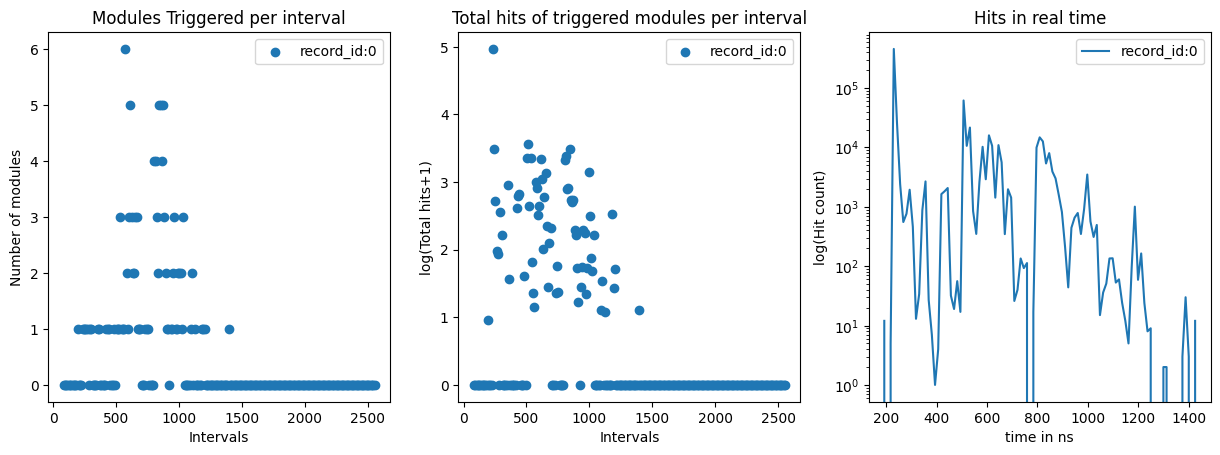

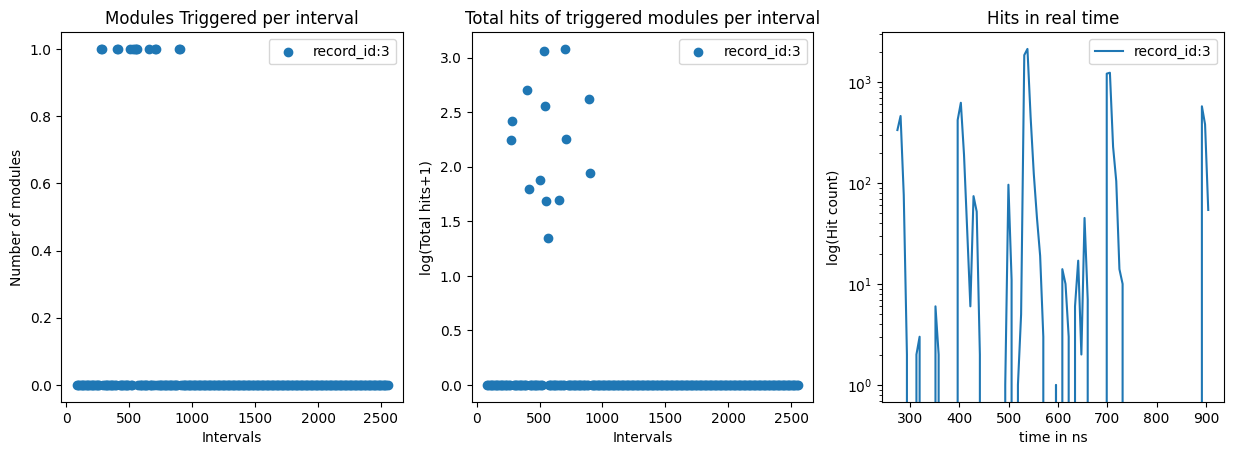

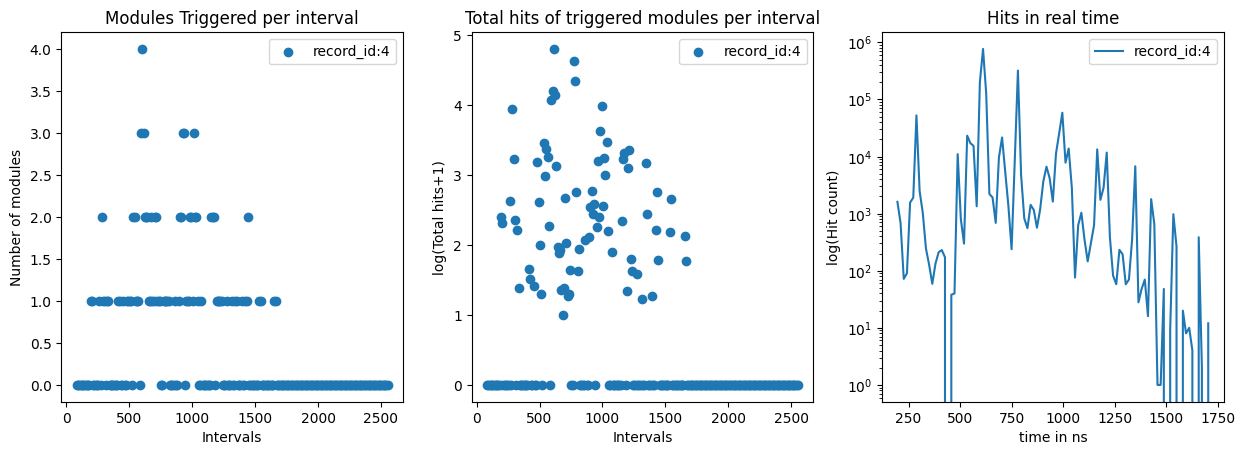

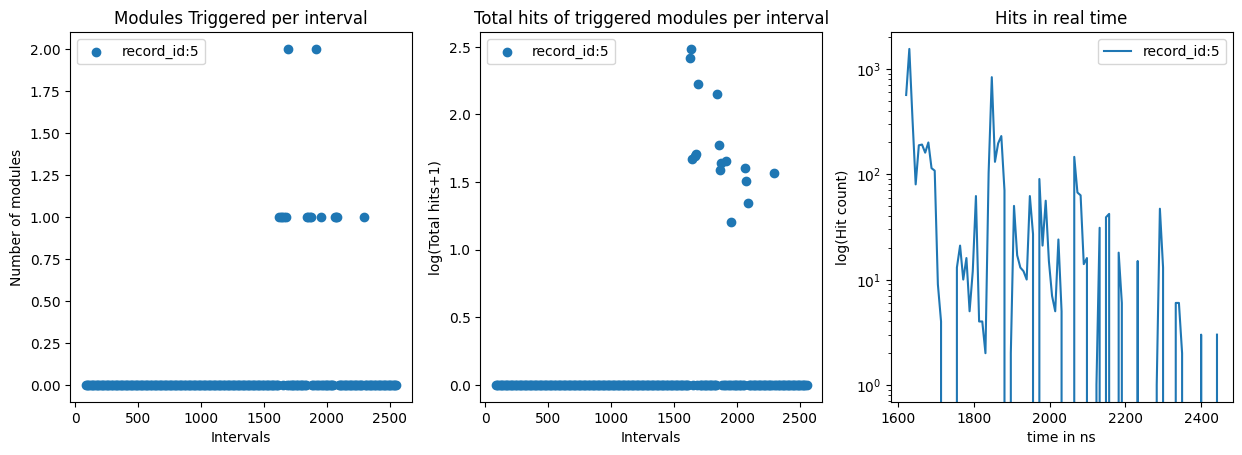

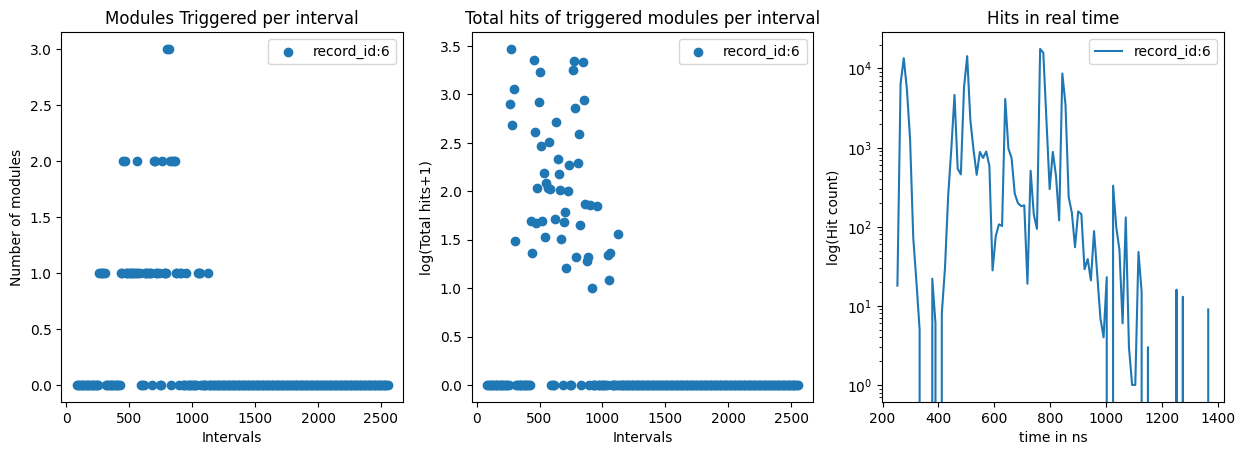

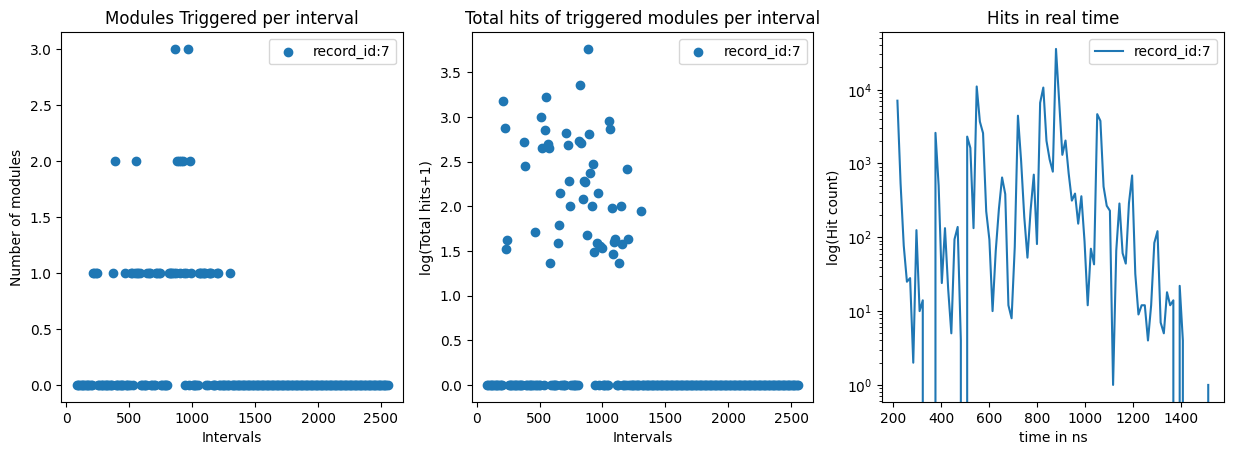

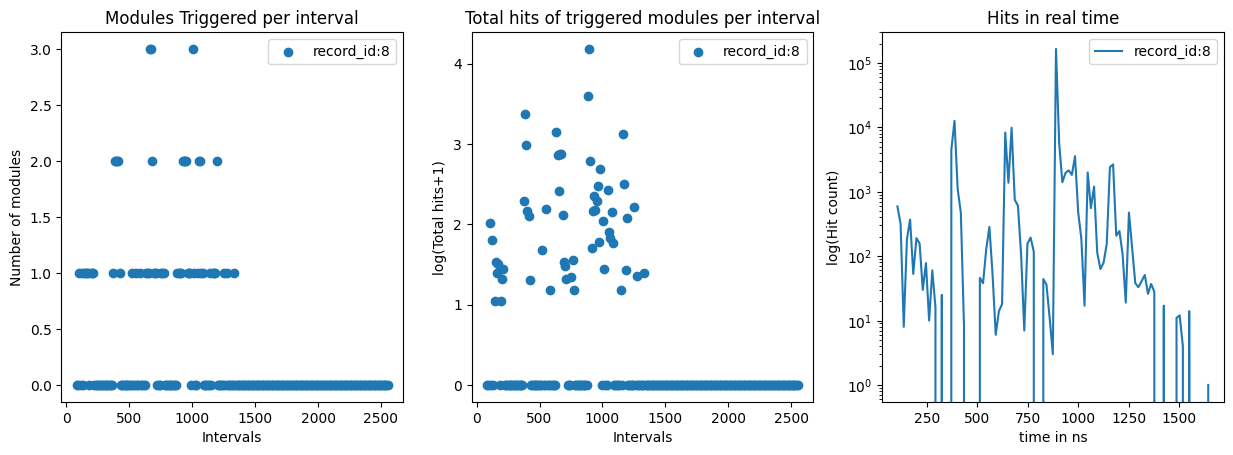

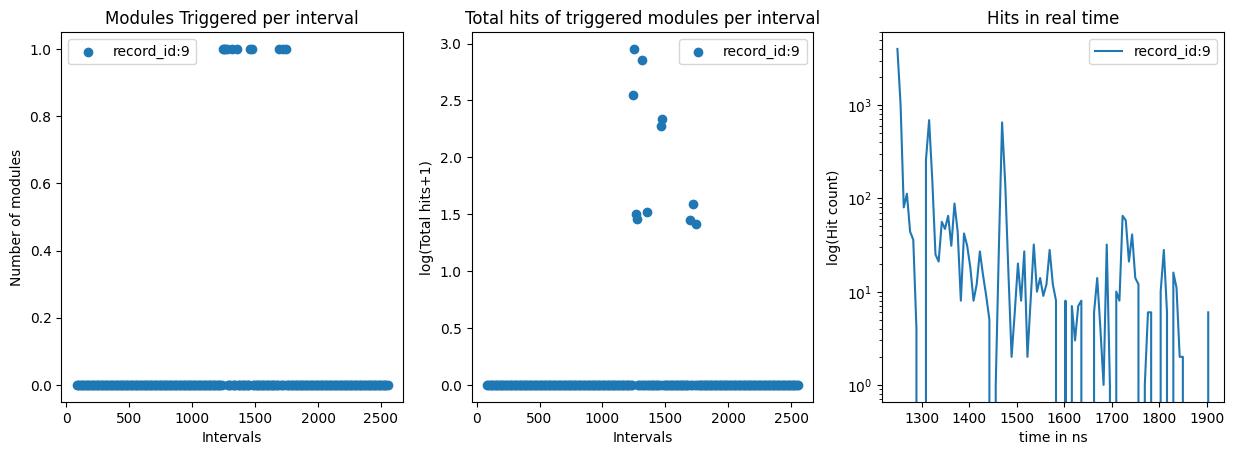

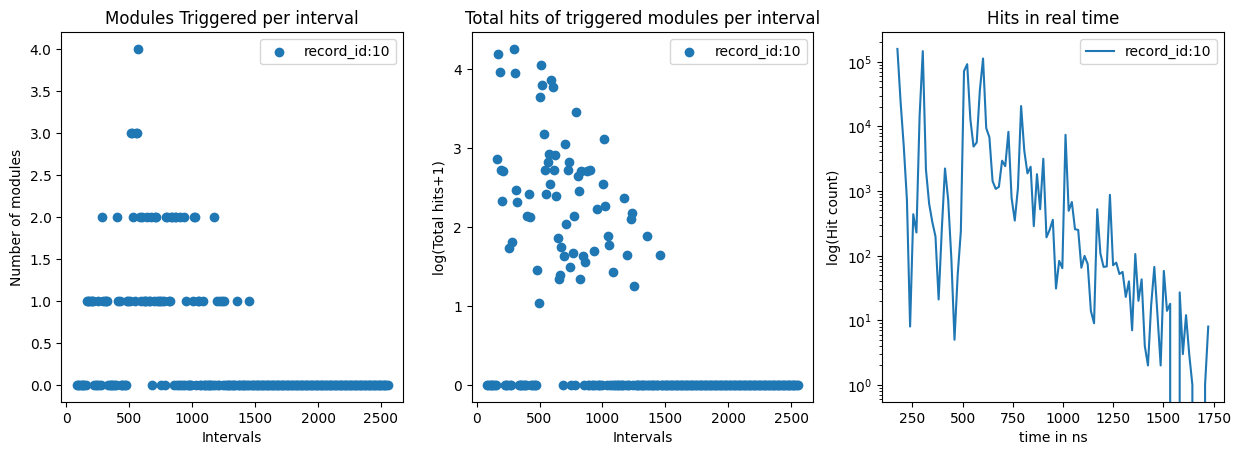

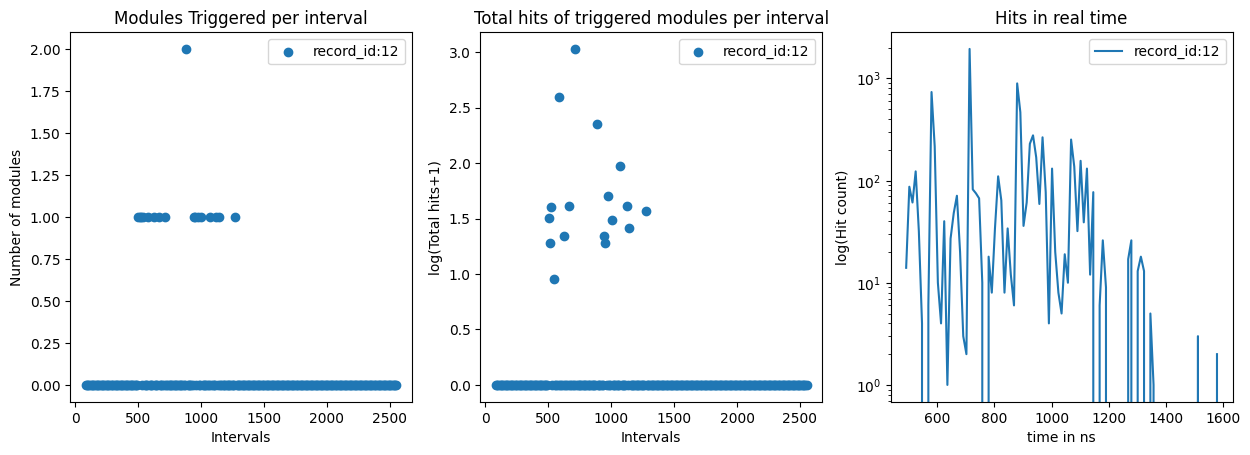

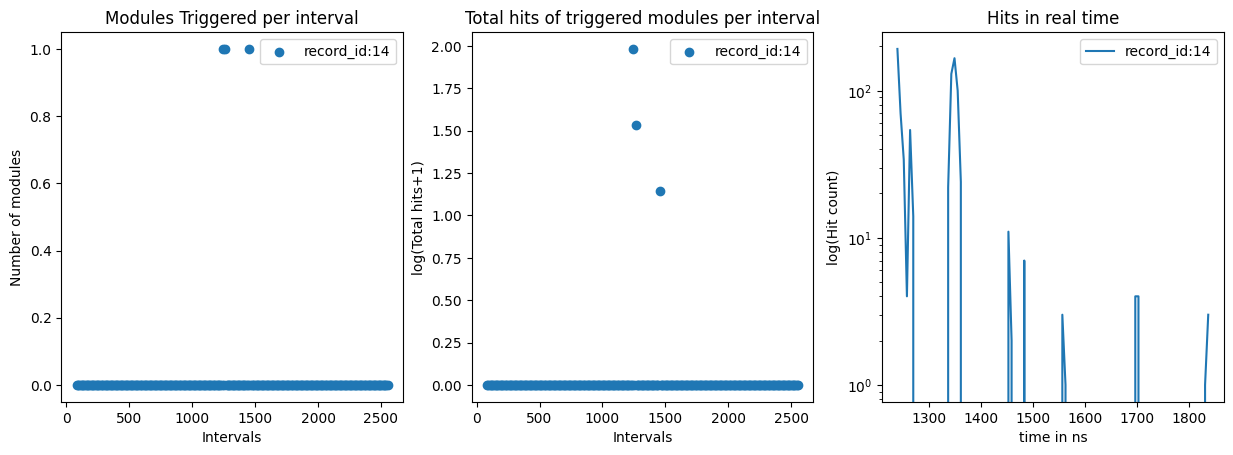

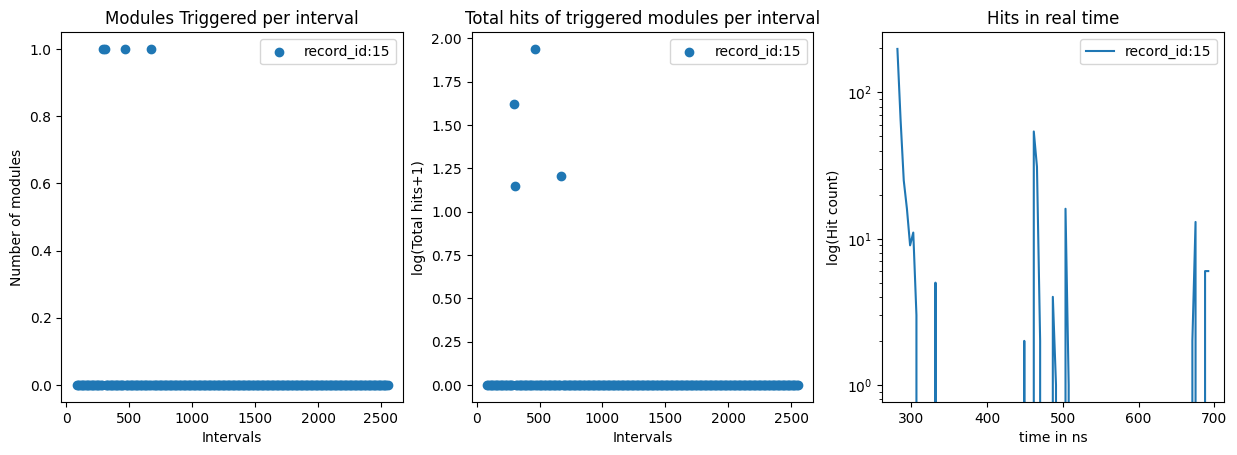

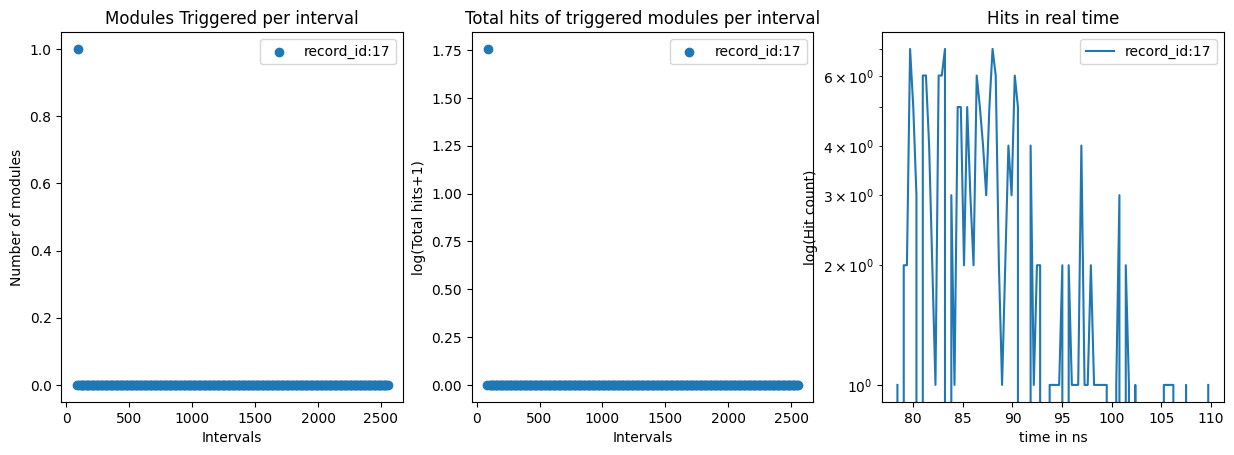

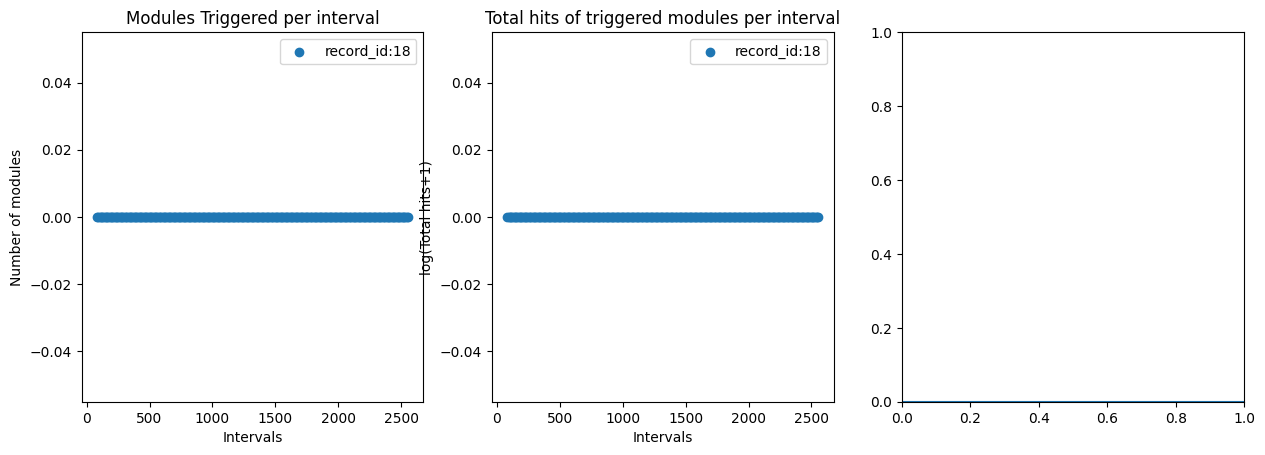

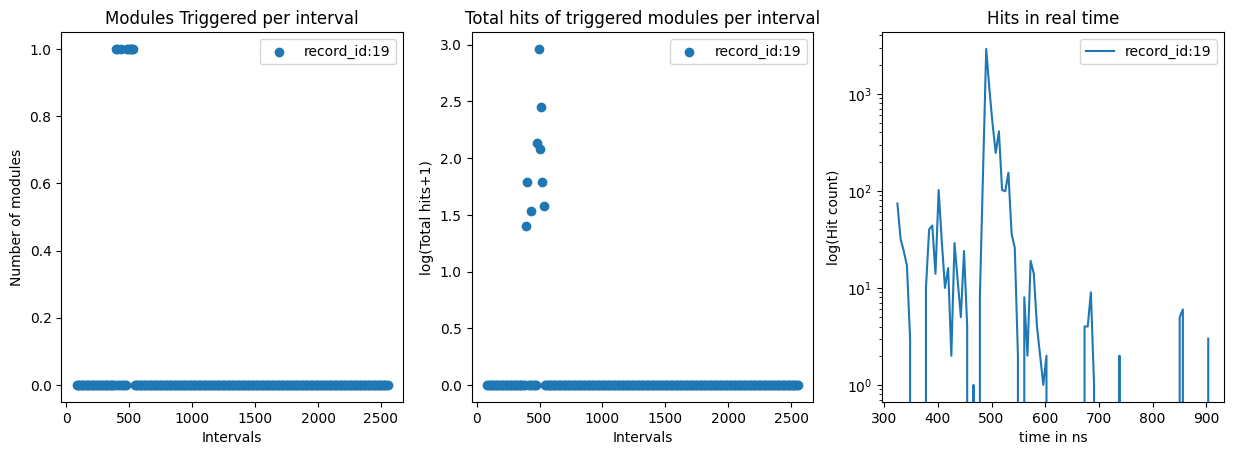

In [14]:
count=0
for (number_of_modules_triggered,hits_per_interval,hit_times,record) in \
zip(result[0],result[1],result[2],records.df['record_id']):
    plt.figure().set_figwidth(15)
    #plt.suptitle('For '+path[5:])
    plt.subplot(1, 3, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    data=np.array(hit_times.sum())
    if data.size==1:
        plt.axhline(y=0,label='record_id:'+str(record))
        continue
    bins = np.linspace(min(data), max(data), num=100)  
    # Count occurrences in each bin
    counts, _ = np.histogram(data, bins)
    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot as a line plot
    plt.plot(bin_centers, counts,label='record_id:'+str(record))
    plt.xlabel('time in ns')
    plt.ylabel('log(Hit count)')
    plt.yscale('log')
    plt.title('Hits in real time')
    plt.legend()

    #plt.suptitle('For '+path[5:])
    plt.show()

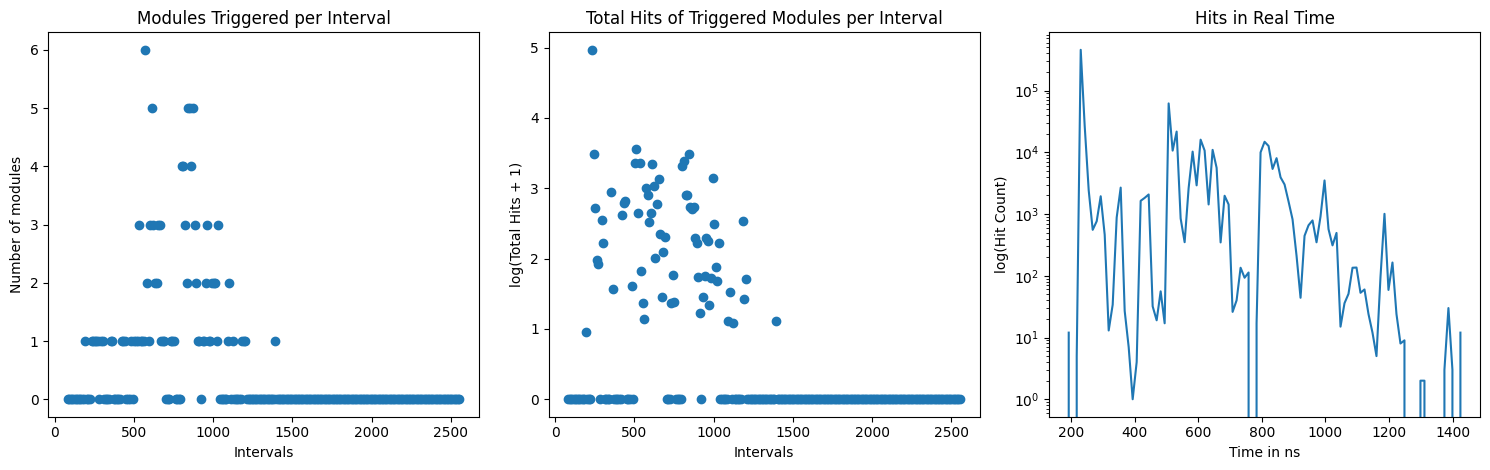

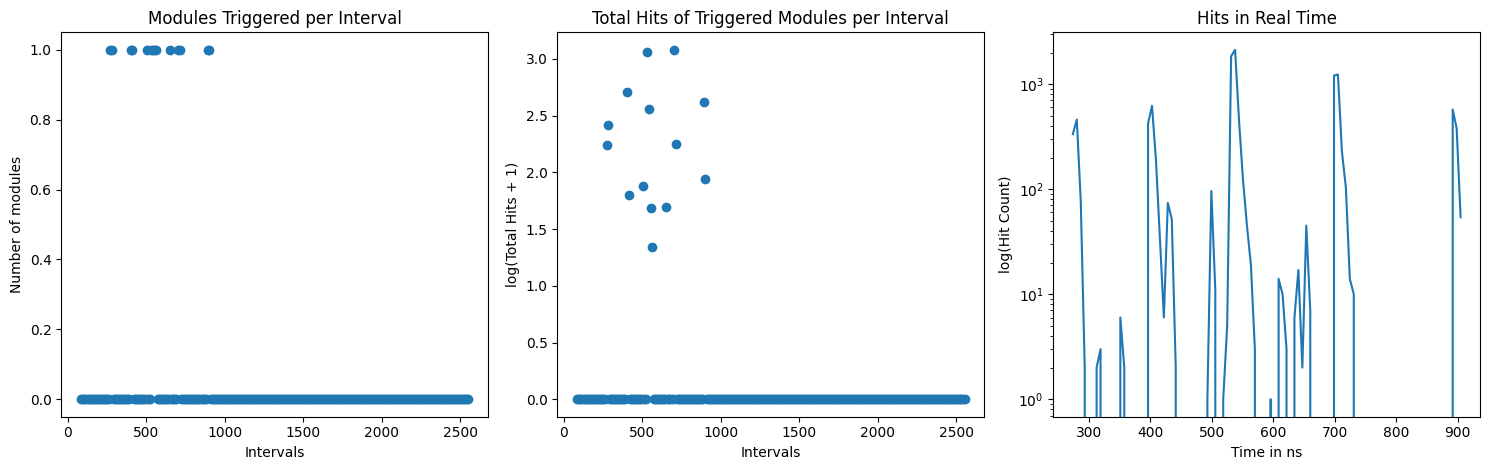

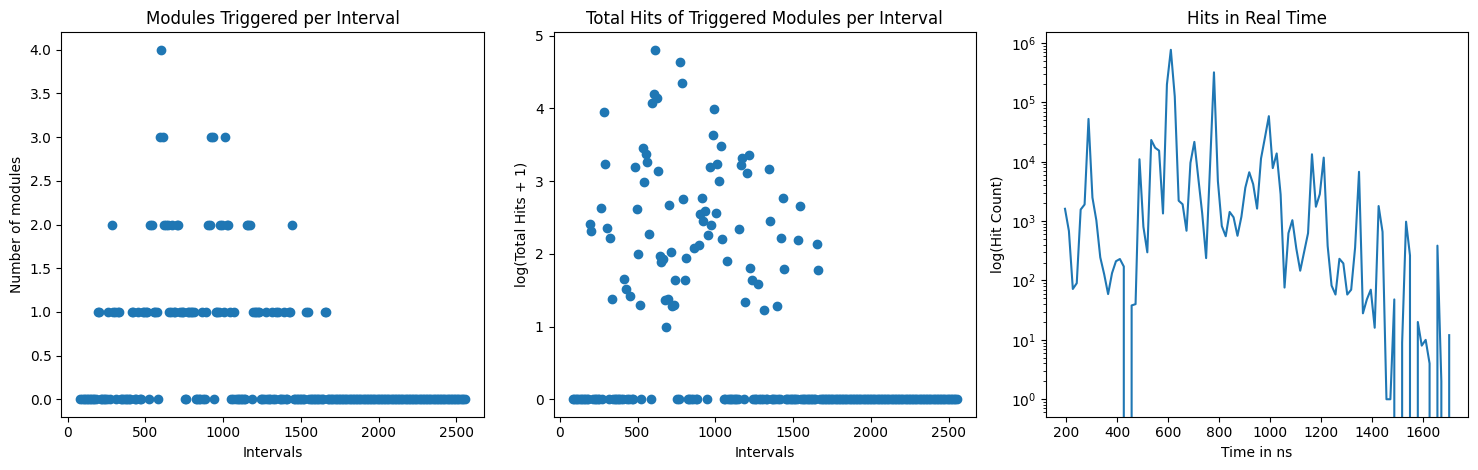

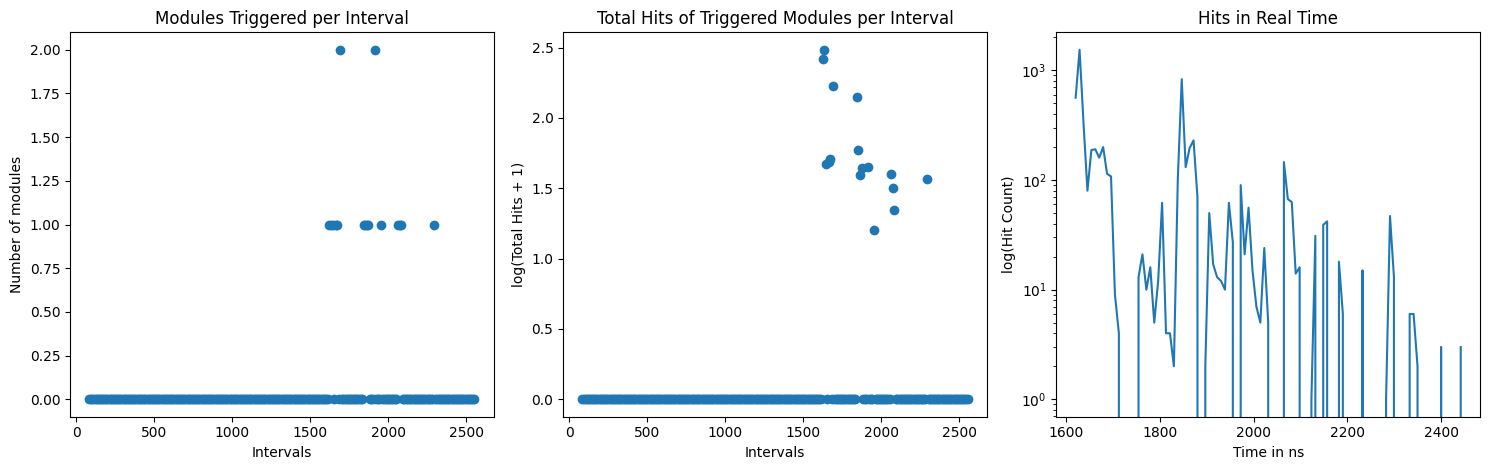

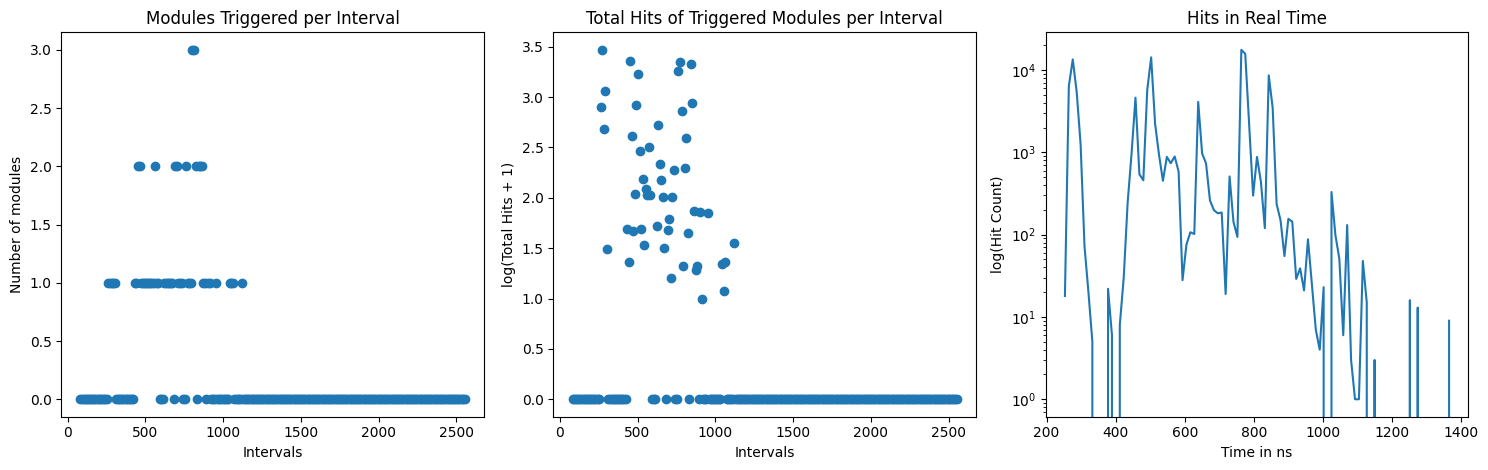

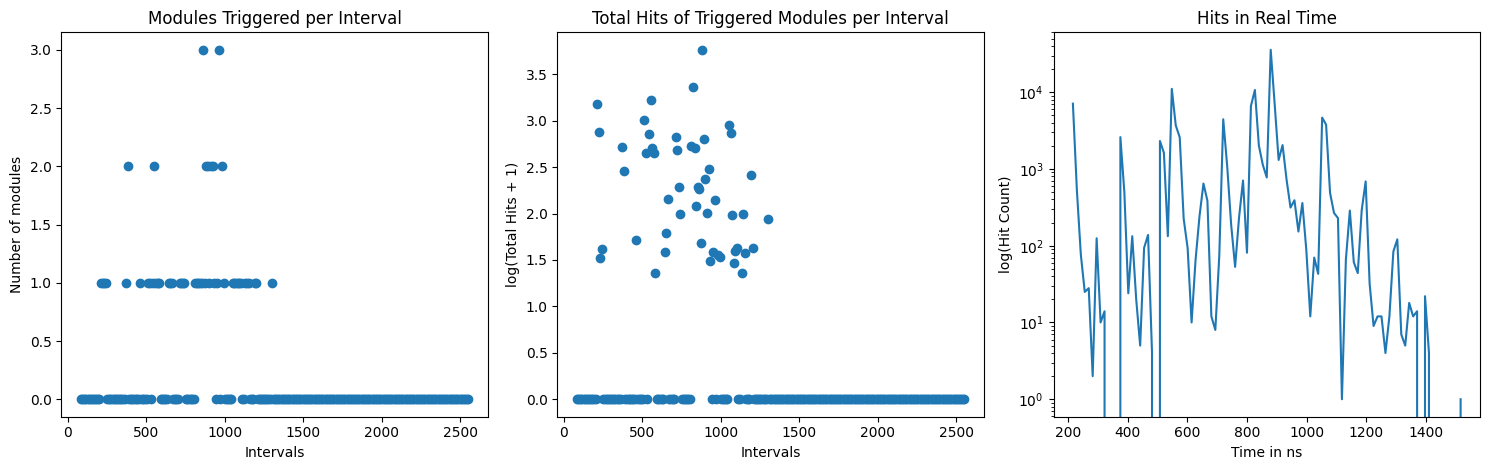

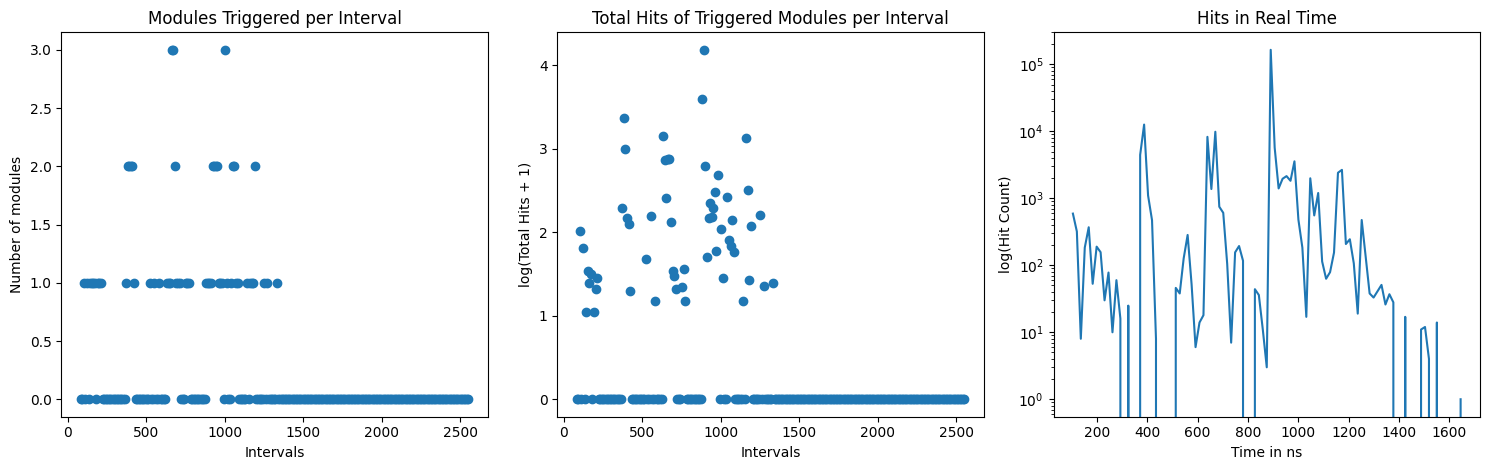

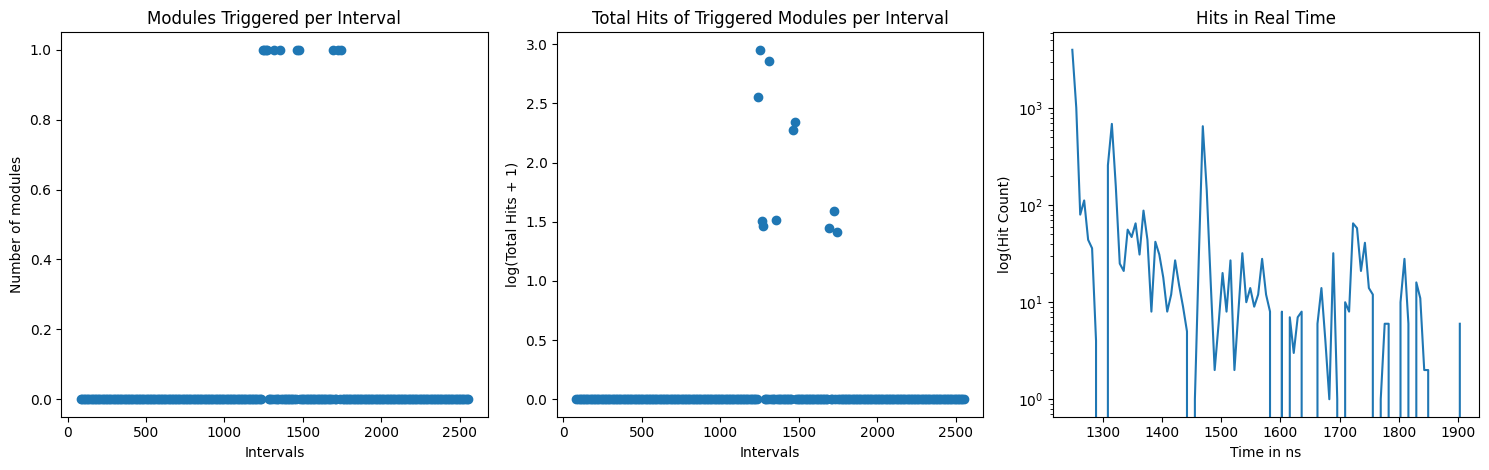

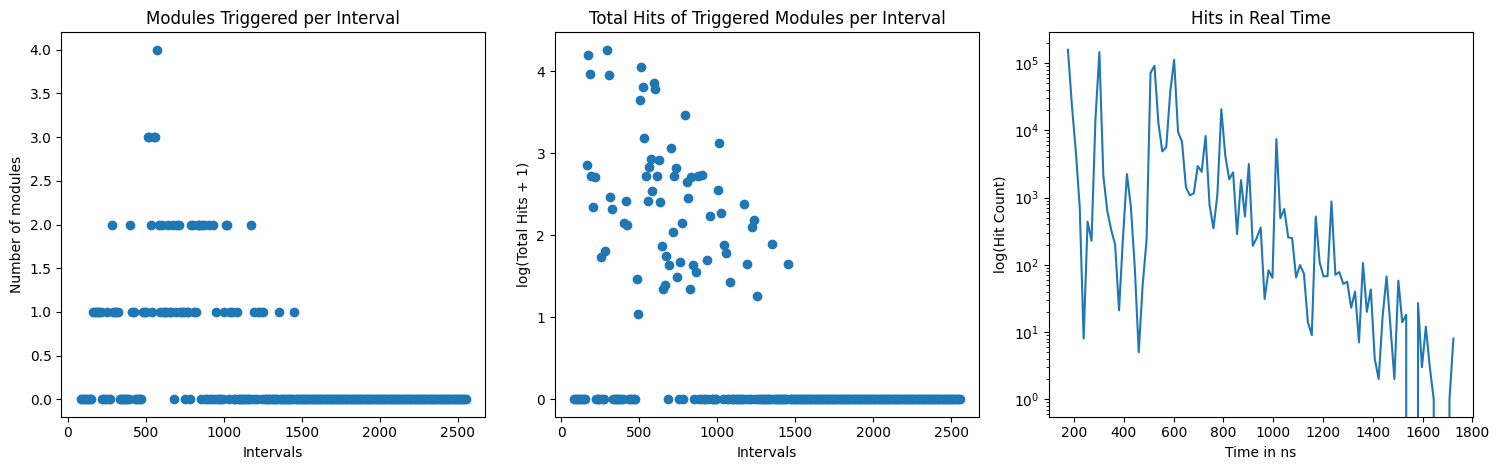

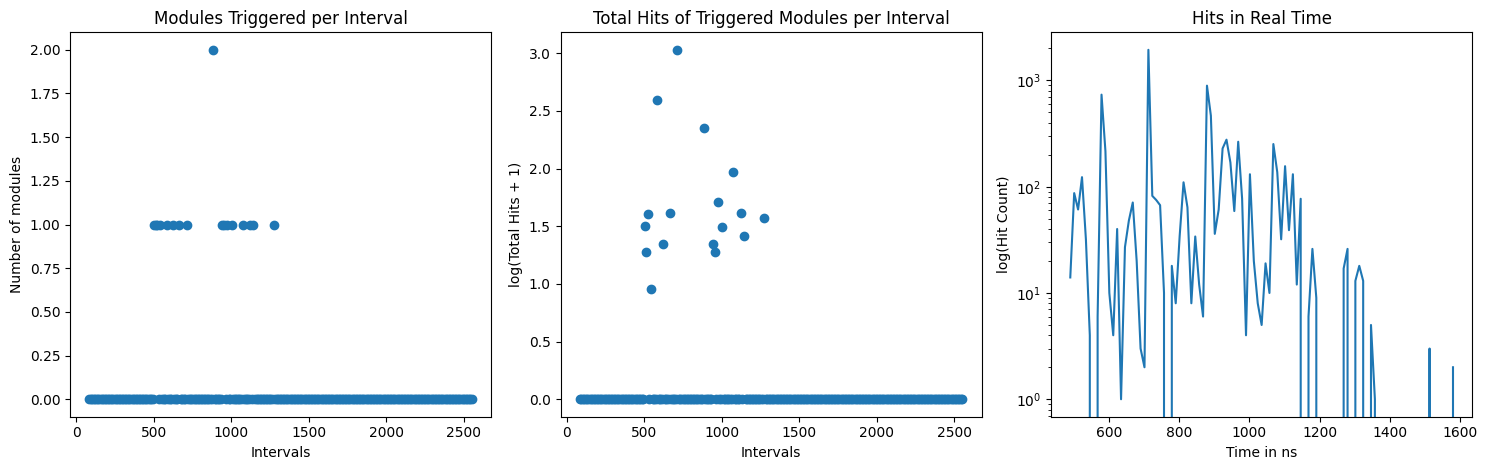

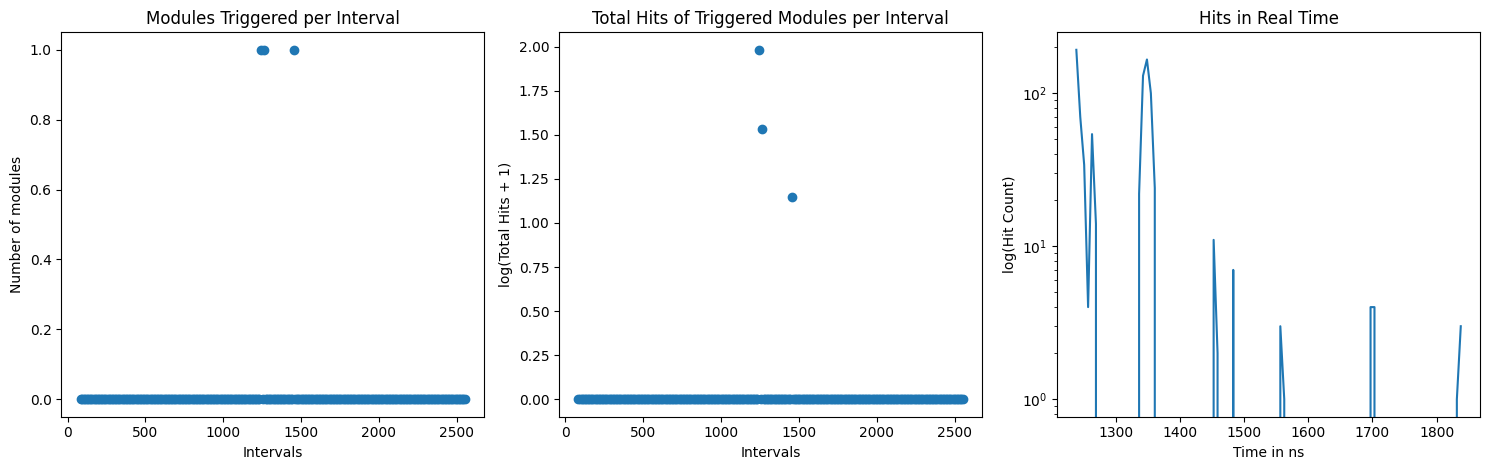

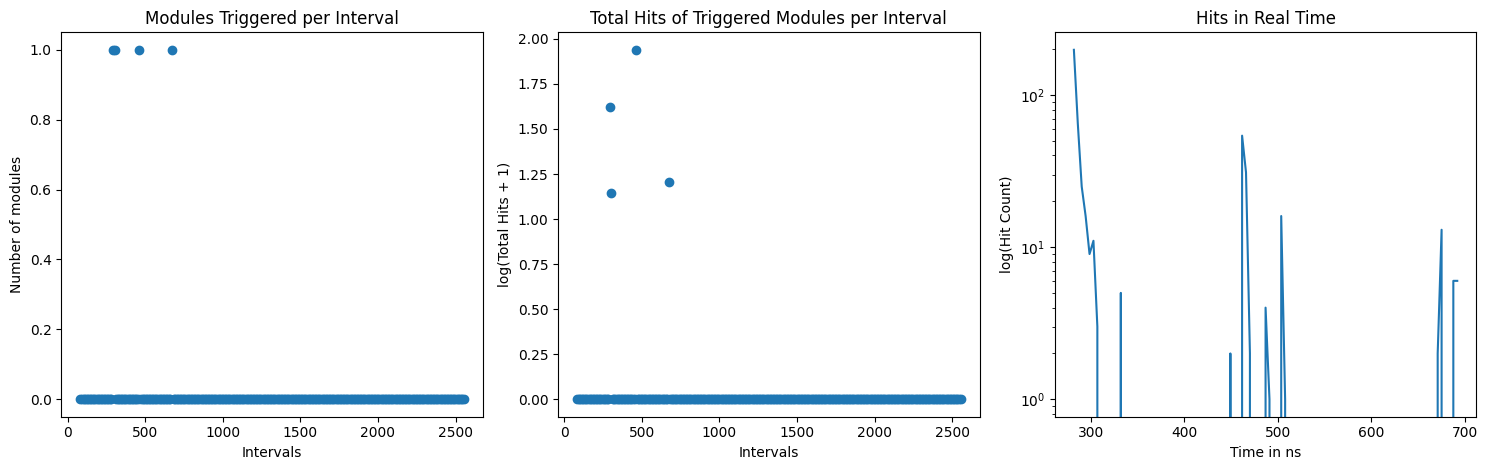

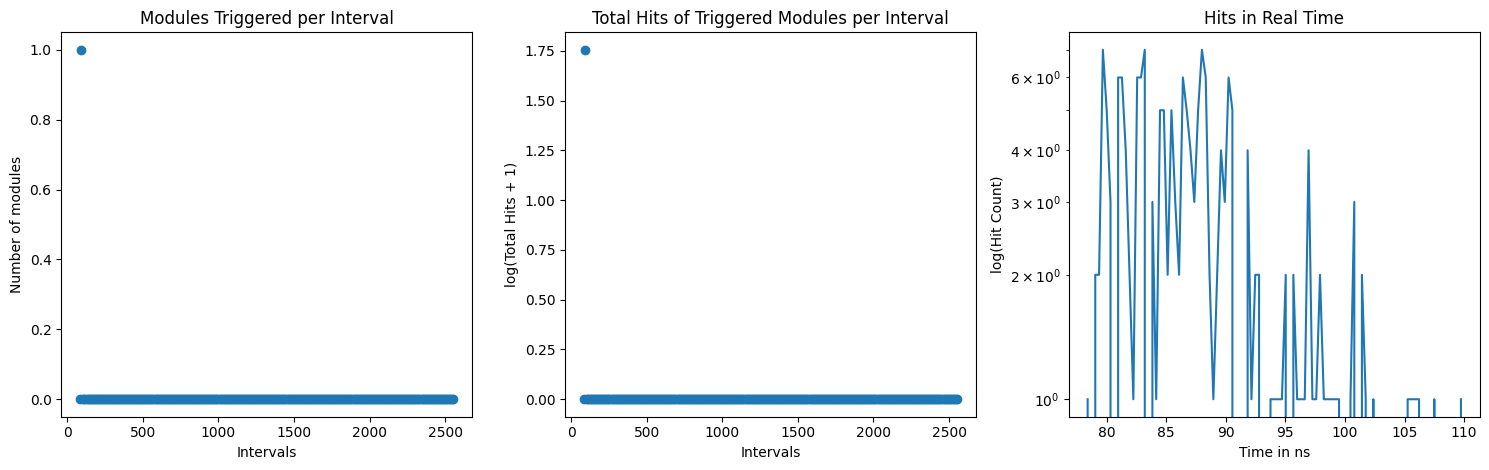

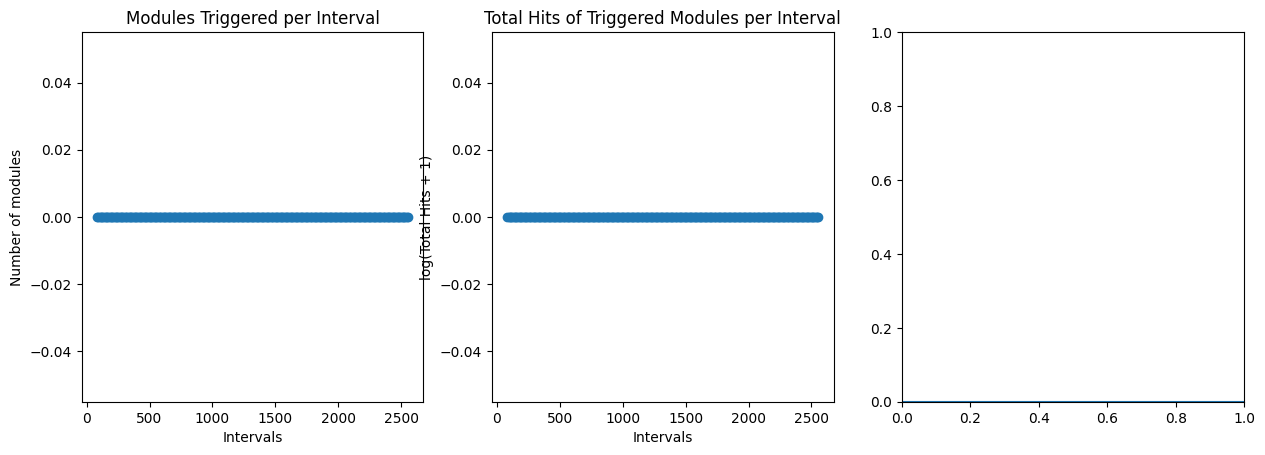

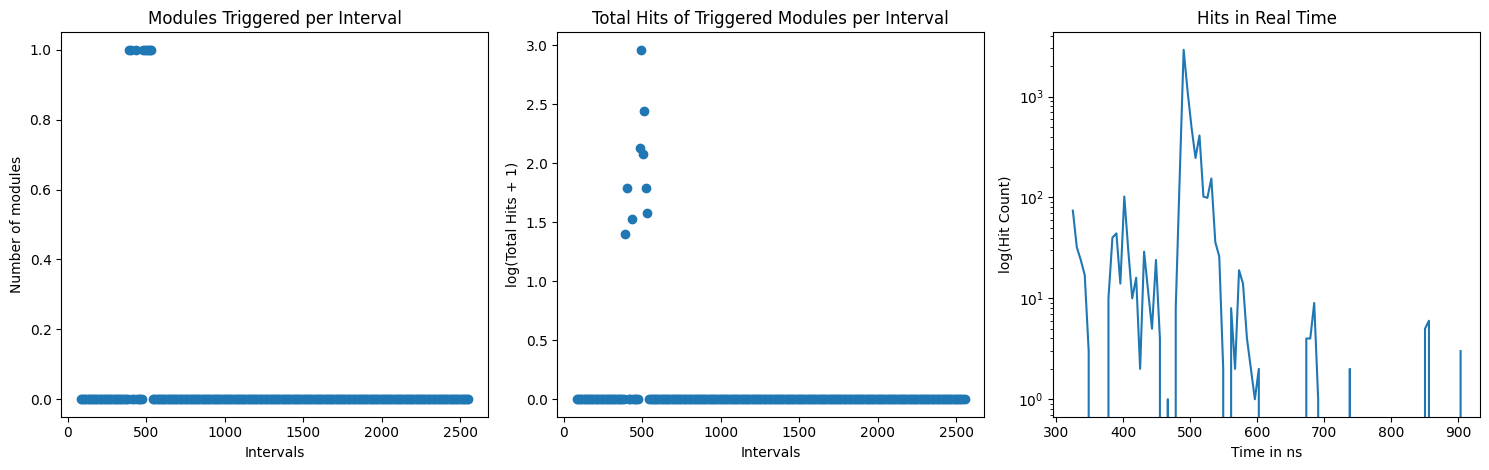

In [11]:
tc.plot(result[0],result[1],result[2],records.df['record_id'],result[3])

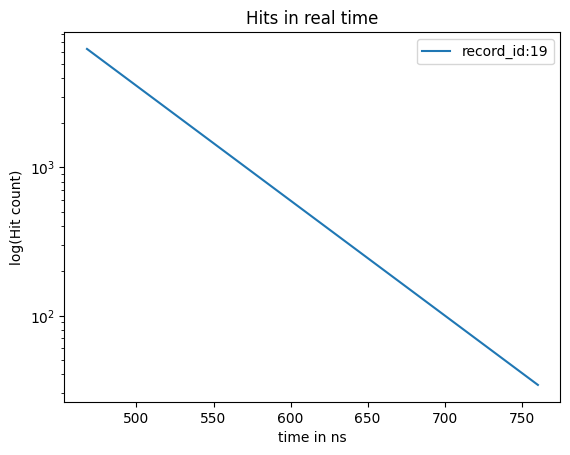

In [20]:
data=np.array(hit_times.sum())

bins = np.linspace(min(data), max(data), num=)  
# Count occurrences in each bin
counts, _ = np.histogram(data, bins)
# Calculate bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2
# Plot as a line plot
plt.plot(bin_centers, counts,label='record_id:'+str(record))
plt.xlabel('time in ns')
plt.ylabel('log(Hit count)')
plt.yscale('log')
plt.title('Hits in real time')
plt.legend()

#plt.suptitle('For '+path[5:])
plt.show()

In [27]:
len(data)/(max(data)-min(data))#hits per ns

10.835066438692422

In [30]:
np.log10(len(data)/(max(data)-min(data))*10**9/)

10.034831578680206